# Unsupervised Learning of Edge Orientation
* Synthetic Dataset from MuJoCo simulator
* Brian2

INFO:root:/home/fraaw/miniconda3/envs/tac3d/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/fraaw/miniconda3/envs/tac3d/include -fPIC -O2 -isystem /home/fraaw/miniconda3/envs/tac3d/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/fraaw/miniconda3/envs/tac3d/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/fraaw/miniconda3/envs/tac3d/include -fPIC -c /tmp/tmpwbct40jq.cpp -o tmp/tmpwbct40jq.o -w
INFO:root:/home/fraaw/miniconda3/envs/tac3d/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/fraaw/miniconda3/envs/tac3d/include -fPIC -O2 -isystem /home/fraaw/miniconda3/envs/tac3d/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/fraaw/miniconda3/envs/tac3d/include -DNDEBUG -D_FO

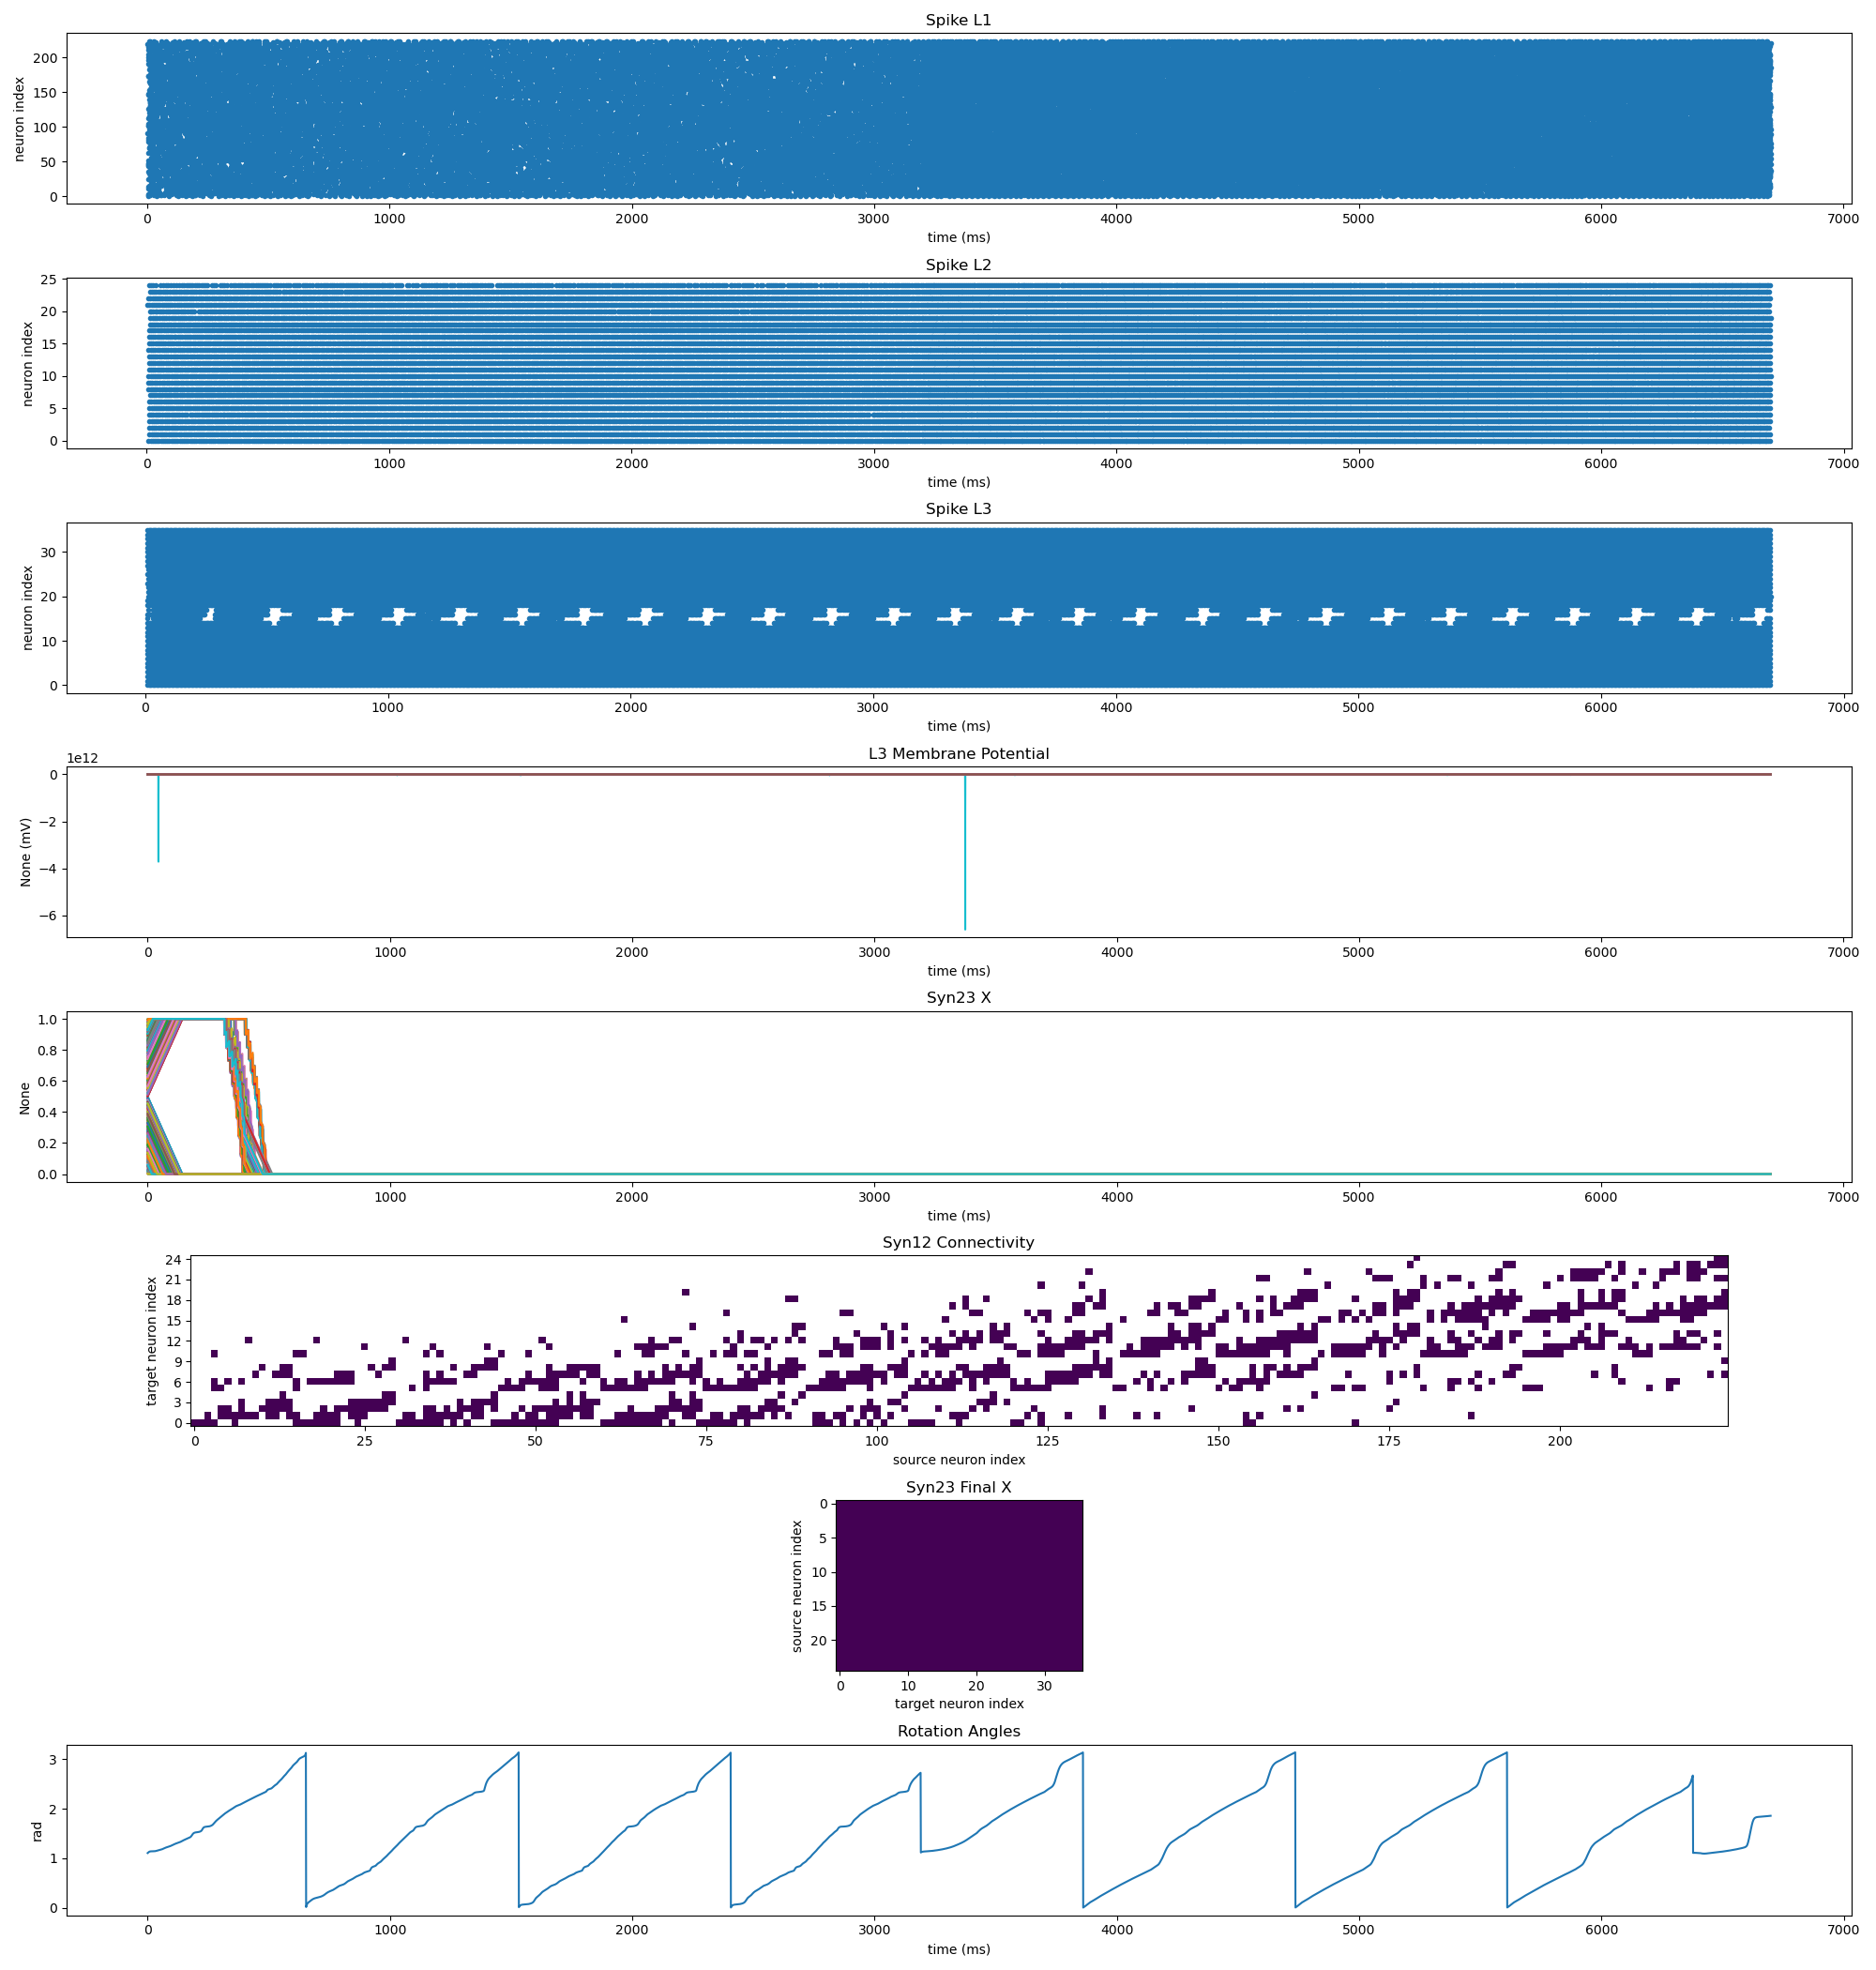

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
from brian2tools import brian_plot, plot_state
from TacNet import TacNet
from TouchDataset import TouchDataset

set_device("cpp_standalone")


def wrap2pi(angles):
    theta = np.array(angles)
    theta = theta.reshape(-1)
    n = np.floor(theta / np.pi)
    return theta - n * np.pi


# Prepare dataset
n = 1
dataset = TouchDataset("../data/touch.pkl", flatten=False)
X_train, y_train, X_test, y_test = dataset.split_set(ratio=0.7)
data, orientations = np.repeat(X_train, n, axis=0), np.repeat(y_train, n, axis=0)

# Convert values to spikes
dt = 1 * ms
length, height, width = data.shape
inputs = data.reshape(length, -1)
inputs[inputs > 0] = 1.0
I = TimedArray(inputs * 200 * pA, dt=dt)

# Prepare simulation
duration = I.values.shape[0] * dt
num_neurons = [height * width, 25, 36]
model = TacNet(num_neurons)
mons = model.run(I, duration)

# Plot results
fig, axs = plt.subplots(8, 1, figsize=(20, 21))
for i in range(3):
    axs[i].set_title("Spike L" + str(i + 1))
    brian_plot(mons["SpikeMonitor_L" + str(i + 1)], axes=axs[i])

axs[3].set_title("L3 Membrane Potential")
plot_state(mons["StateMonitor_L3"].t, mons["StateMonitor_L3"].v.T, axes=axs[3])
axs[4].set_title("Syn23 X")
plot_state(mons["StateMonitor_Syn23"].t, mons["StateMonitor_Syn23"].X.T, axes=axs[4])
axs[5].set_title("Syn12 Connectivity")
brian_plot(model.net["Syn12"], axes=axs[5])
axs[6].set_title("Syn23 Final X")
axs[6].set_xlabel("target neuron index")
axs[6].set_ylabel("source neuron index")
axs[6].imshow(model.net["Syn23"].X_[:].reshape((num_neurons[1], num_neurons[2])))
axs[7].plot(wrap2pi(orientations))
axs[7].set_title("Rotation Angles")
axs[7].set_xlabel("time (ms)")
axs[7].set_ylabel("rad")
plt.tight_layout()
plt.show()

# Generative MGGD Spatial Model

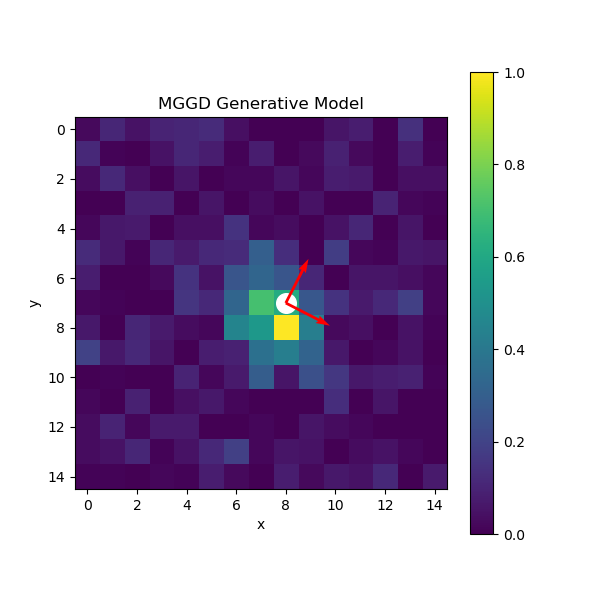

In [3]:
%matplotlib widget
from random import random

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from numpy import linalg as LA


def genScatter(alpha=None, p=2):
    if alpha is None:
        alpha = random() * 2 * np.pi
    beta = alpha + np.pi / 2.0

    Q = np.array([[np.cos(alpha), np.cos(beta)], [np.sin(alpha), np.sin(beta)]])
    P = np.diag(np.random.rand(2))
    M = np.matmul(np.matmul(Q, P), LA.inv(Q))

    return M * p / M.trace()


def normalize2(xs, scope, dtype=int):
    xs = (xs - xs.min()) / (xs.max() - xs.min()) * (scope - 1)
    return np.clip(np.round(xs), 0, scope - 1).astype(dtype)


def generate_image(beta, m, M, p=2):
    nsamples = 1000
    # Stochastic process
    Sigma = np.sqrt(np.abs(m * M))
    phi = 2 * np.pi * np.random.random(nsamples) - np.pi
    u = np.array([np.cos(phi), np.sin(phi)])
    tau = np.power(np.random.gamma(0.5 * p / beta, 2, nsamples), 0.5 / beta)
    x = tau * np.matmul(Sigma, u)

    x = normalize2(x, 15)

    im = np.zeros((15, 15), dtype=int)
    for ns in np.arange(nsamples):
        im[x[0, ns], x[1, ns]] += 1
    noise = np.random.normal(np.mean(im), 0.5 * np.sqrt(np.var(im)), im.shape)
    im += np.round(noise).astype(int)
    im[im < 0] = 0
    im = (im - im.min()) / (im.max() - im.min())

    X, Y = np.meshgrid(np.linspace(1, 16, 15), np.linspace(1, 16, 15))
    center = (
        np.round(np.sum(X * im / np.sum(im))) - 1,
        np.round(np.sum(Y * im / np.sum(im))) - 1,
    )
    w, v = LA.eig(M)
    X = [center[1], center[1]]
    Y = [center[0], center[0]]
    U = v[0, :]
    V = v[1, :]

    return im, center, v


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
im, center, v = generate_image(0.5, 10, genScatter())
image = ax.imshow(im)
dot = ax.scatter(center[1], center[0], s=200, c="w")
quiver = ax.quiver(
    [center[1], center[1]],
    [center[0], center[0]],
    v[0, :],
    v[1, :],
    color="r",
    scale_units="xy",
    scale=0.5,
)
fig.colorbar(image, ax=ax)


def init():
    im, center, v = generate_image(
        np.random.rand(1) * 6, np.random.rand(1) * 15, genScatter()
    )
    image.set_data(im)
    dot.set_offsets(center)
    quiver.set_offsets(np.asarray([center, center]))
    quiver.set_UVC(v[0, :], v[1, :])

    return image, dot, quiver


def update(frame):
    im, center, v = generate_image(
        np.random.rand(1) * 6, np.random.rand(1) * 15, genScatter()
    )
    image.set_data(im)
    dot.set_offsets(center)
    quiver.set_offsets(np.asarray([center, center]))
    quiver.set_UVC(v[0, :], v[1, :])

    return image, dot, quiver


ani = FuncAnimation(fig, update, frames=1000, interval=400, init_func=init, blit=True)

plt.title("MGGD Generative Model")
plt.show()

# Tactile Encoder with Nengo

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
from nengo_extras.data import load_mnist, one_hot_from_labels
from nengo_extras.matplotlib import tile
from nengo_extras.vision import Gabor, Mask
from TouchDataset import TouchDataset


def conv_layer(x, *args, activation=True, **kwargs):
    # create a Conv2D transform with the given arguments
    conv = nengo.Convolution(*args, channels_last=False, **kwargs)

    if activation:
        # add an ensemble to implement the activation function
        layer = nengo.Ensemble(n_neurons=conv.output_shape.size, dimensions=1).neurons
    else:
        # no nonlinearity, so we just use a node
        layer = nengo.Node(size_in=conv.output_shape.size)

    # connect up the input object to the new layer
    nengo.Connection(x, layer, transform=conv)

    # print out the shape information for our new layer
    print("Convolutional Layer")
    print(conv.input_shape.shape, "->", conv.output_shape.shape)

    return layer, conv


nRows, nCols = 15, 15

# prepare dataset
dataset = TouchDataset("../data/touch.pkl", flatten=True, normalize=(-1, 1))
X_train, y_train, X_test, y_test = dataset.split_set(ratio=0.9)

dt = 1e-3  # simulation timestep
presentation_time = 0.1  # input presentation time
n_presentations = 1
max_rate = 200  # neuron firing rates
# neuron spike amplitude (scaled so that the overall output is ~1)
amp = 1 / max_rate
# input image shape
input_shape = (1, nRows, nCols)
n_parallel = 1  # number of parallel network repetitions

with nengo.Network(seed=0) as net:
    # set up the default parameters for ensembles/connections
    net.config[nengo.Ensemble].neuron_type = nengo.SpikingRectifiedLinear(amplitude=amp)
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    # the input node that will be used to feed in input images
    inp = nengo.Node(
        nengo.processes.PresentInput(X_test, presentation_time), size_out=nRows * nCols
    )

    # the output node provides the 36-dimensional classification
    out = nengo.Node(size_in=36)

    # build parallel copies of the network
    for _ in range(n_parallel):
        layer, conv = conv_layer(
            inp, 1, input_shape, kernel_size=(1, 1), init=np.ones((1, 1, 1, 1))
        )
        # first layer is to translate the images into spikes
        # net.config[layer.ensemble].on_chip = False
        layer, conv = conv_layer(layer, 6, conv.output_shape, strides=(2, 2))
        layer, conv = conv_layer(layer, 12, conv.output_shape, strides=(2, 2))
        nengo.Connection(layer, out, transform=nengo_dl.dists.Glorot())

    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=nengo.Alpha(0.01), label="out_p_filt")

with nengo.Simulator(net, dt=dt) as sim:
    sim.run(n_presentations * presentation_time * len(X_test))
    # check output
    step = int(presentation_time / dt)
    output = sim.data[out_p_filt][step - 1 :: step]
    print(output.shape)